In [120]:
import numpy as np
np.set_printoptions(suppress=True)

import pandas as pd
pd.set_option('display.max_colwidth', -1)

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import seaborn as sns
sns.set_style('white')

from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit

import json
from pprint import pprint
from functools import reduce

import keras
from keras.preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# from shopee_challenge_customlib import get_attributes_lookup

In [2]:
mobile_info_train = pd.read_csv('./dataset/mobile_data_info_train_competition.csv')
mobile_info_test = pd.read_csv('./dataset/mobile_data_info_val_competition.csv')
mobile_profile = pd.read_json('./dataset/mobile_profile_train.json')

In [29]:
# image_path_ubuntu = '/media/terence/hd_storage/sam/shopee-images'

In [ ]:
def get_attributes_lookup(df):
    
    attributes_lookup = {}
    num_total_categories = 0
    
    for attribute in df.columns:
        num_categories_per_attribute = 0
        
        cat_keys = df[attribute][df[attribute].notnull()].values
        cat_values = df[attribute][df[attribute].notnull()].index
        attributes_lookup[attribute] = dict(zip(cat_keys, cat_values))
        
        num_total_categories += len(cat_keys)
        
    if num_total_categories > len(df):
        print('1 profile type falls under more than attribute. Manually check profiles.')
        print('No. of df rows: ', len(df))
        print('No. of categories: ', num_total_categories)
    elif num_total_categories < len(df):
        print('Some rows in original dataframe might be unaccounted for or entirely composed of NaNs. Check input df.')
        print('No. of df rows: ', len(df))
        print('No. of categories: ', num_total_categories)
    elif num_total_categories == len(df):
        print('All good. Number of lookup categories == rows in input df.')
        
    return attributes_lookup

In [3]:
mobile_lookup = get_attributes_lookup(mobile_profile)

1 profile type falls under more than attribute. Manually check profiles.
No. of df rows:  2433
No. of categories:  2443


In [153]:
mobile_lookup['Color Family'][26.0] = 'NaN'

In [4]:
def factors(n):    
    return set(reduce(list.__add__, 
                ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0)))

In [5]:
def preprocess_df_for_image(df, attribute=None):
    
    try: 
        transformed = df[['itemid', 'image_path', attribute]].copy()
        #change this to regex later
        transformed['image_path'] = transformed['image_path'].apply(lambda x: 
                                                                    x[len('mobile_image/'):])
        
        nan_label = df[attribute].max() + 1
        transformed[attribute].fillna(nan_label, inplace=True)
        
        ohe = pd.DataFrame(keras.utils.to_categorical(transformed[attribute]))
        
        transformed = pd.concat([transformed, ohe], axis=1)
        
    except KeyError: 
        transformed = df[['itemid', 'image_path']].copy()
        #change this to regex later
        transformed['image_path'] = transformed['image_path'].apply(lambda x: 
                                                                    x[len('mobile_image/'):])
        
    return transformed

In [9]:
# manually train test split
def train_val_test_split(vertical_df_train, vertical_df_test, attribute, test_size=0.2):
    
    test_df = preprocess_df_for_image(vertical_df_test)
    attr_df = preprocess_df_for_image(vertical_df_train, attribute)
    
    # to use stratified shuffle split, must get rid of train labels with only one instance
    sss = ShuffleSplit(n_splits=1, test_size=test_size)
    
    for train_index, val_index in sss.split(np.zeros(len(vertical_df_train)), 
                                            vertical_df_train[attribute]):
        train_df = attr_df.iloc[train_index].reset_index() # must reset index else generator will throw error
        val_df = attr_df.iloc[val_index].reset_index()
        
    print('Train Rows: ', len(train_df))
    print('Val Rows: ', len(val_df))
    print('Test Rows: ', len(test_df))
    
    train_prp = train_df[attribute].value_counts()/len(train_df)
    val_prp = val_df[attribute].value_counts()/len(val_df)
    
    prp_comparison = pd.concat([train_prp, val_prp], axis=1, sort=False)
    prp_comparison.columns = ['Train', 'Val']
    print(prp_comparison)
 
    return train_df, val_df, test_df

In [22]:
colorfam_img_train, colorfam_img_val, colorfam_img_test = train_val_test_split(mobile_info_train, 
                                                                               mobile_info_test, 
                                                                               'Color Family', 
                                                                               0.2)

Train Rows:  128264
Val Rows:  32066
Test Rows:  40417
         Train       Val
0.0   0.106616  0.108744
1.0   0.001965  0.002339
2.0   0.004272  0.003836
3.0   0.000008 NaN      
4.0   0.024489  0.024200
6.0   0.005185  0.005707
7.0   0.002401  0.002370
10.0  0.233199  0.231990
11.0  0.001208  0.001279
12.0  0.048884  0.050303
13.0  0.043761  0.043223
14.0  0.002386  0.002089
16.0  0.000405  0.000343
17.0  0.000133  0.000187
18.0  0.000507  0.000437
19.0  0.034983  0.034585
20.0  0.014821  0.014283
22.0  0.000031 NaN      
23.0  0.000008 NaN      
24.0  0.000008 NaN      
25.0  0.003703  0.003711
26.0  0.471029  0.470374


In [23]:
colorfam_img_train.head(2)

,index,itemid,image_path,Color Family,0,1,2,3,4,5,...,17,18,19,20,21,22,23,24,25,26
0,112145,1296556499,78bfceb713a18c94595f84f5bb19feda.jpg,26.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,50663,975294142,889fbb6744207a303756ee8b03ab8f44.jpg,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
train_datagen = ImageDataGenerator(rescale=1/255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1/255)

In [25]:
print(factors(len(colorfam_img_train)))
print(factors(len(colorfam_img_val)))
print(factors(len(colorfam_img_test)))

{1, 2, 32066, 64132, 4, 16033, 128264, 8}
{1, 32066, 2, 16033}
{1, 13, 3109, 40417}


In [37]:
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64
TEST_BATCH_SIZE = 13
TARGET_SIZE = (8, 8)

input_shape = (TARGET_SIZE[0], TARGET_SIZE[1], 3)

In [28]:
# manual split implementation - throws an error
# maybe must one hot encode before manually splitting
# for other way - can i get the validation set indices?
colorfam_train_generator = train_datagen.flow_from_dataframe(dataframe = colorfam_img_train, 
                                                             directory = './dataset/images/mobile_image',
                                                             x_col = 'image_path', 
                                                             y_col = colorfam_img_train.columns[4:],
                                                             shuffle = True,
                                                             class_mode = 'other',
                                                             target_size = TARGET_SIZE, 
                                                             batch_size = TRAIN_BATCH_SIZE)

colorfam_val_generator = test_datagen.flow_from_dataframe(dataframe = colorfam_img_val, 
                                                           directory = './dataset/images/mobile_image',
                                                           x_col = 'image_path', 
                                                           y_col = colorfam_img_train.columns[4:], 
                                                           shuffle = False,
                                                           class_mode = 'other',
                                                           target_size = TARGET_SIZE, 
                                                           batch_size = VAL_BATCH_SIZE)

colorfam_test_generator = test_datagen.flow_from_dataframe(dataframe = colorfam_img_test,
                                                           directory = './dataset/images/mobile_image',
                                                           x_col = 'image_path',
                                                           y_col = None,
                                                           class_mode = None,
                                                           shuffle=False,
                                                           target_size = TARGET_SIZE,
                                                           batch_size = TEST_BATCH_SIZE)

# for test generator, batch size has to be exactly divisible by num of samples 
# so that we don't miss out on any predictions
# if in doubt, put batch_size=1, but it'll be super slow
# always set Shuffle to False for Test Generator

Found 128264 images.
Found 32066 images.
Found 40417 images.


In [209]:
# # keras validation_split implementation

# colorfam_img_train = preprocess_df_for_image(mobile_info_train, 'Color Family')
# colorfam_img_test = preprocess_df_for_image(mobile_info_val)

# train_datagen = ImageDataGenerator(rescale=1/255, 
#                                    shear_range = 0.2, 
#                                    zoom_range = 0.2,
#                                    horizontal_flip = True,
#                                    validation_split = 0.2)

# test_datagen = ImageDataGenerator(rescale=1/255)

# colorfam_train_generator = train_datagen.flow_from_dataframe(dataframe = colorfam_img_train, 
#                                                              directory = './dataset/images/mobile_image',
#                                                              x_col = 'image_path', 
#                                                              y_col = 'Color Family',
#                                                              shuffle = True,
#                                                              subset='training',
#                                                              class_mode = 'categorical',
#                                                              target_size = TARGET_SIZE, 
#                                                              batch_size = TRAIN_BATCH_SIZE)

# colorfam_val_generator = train_datagen.flow_from_dataframe(dataframe = colorfam_img_train, 
#                                                            directory = './dataset/images/mobile_image',
#                                                            x_col = 'image_path', 
#                                                            y_col = 'Color Family',
#                                                            subset = 'validation',
#                                                            shuffle = True,
#                                                            class_mode = 'categorical',
#                                                            target_size = TARGET_SIZE, 
#                                                            batch_size = VAL_BATCH_SIZE)

# colorfam_test_generator = test_datagen.flow_from_dataframe(dataframe = colorfam_img_test,
#                                                            directory = './dataset/images/mobile_image',
#                                                            x_col = 'image_path',
#                                                            y_col = None,
#                                                            class_mode = None,
#                                                            shuffle=False,
#                                                            target_size = TARGET_SIZE,
#                                                            batch_size = TEST_BATCH_SIZE)

# # for test generator, batch size has to be exactly divisible by num of samples 
# # so that we don't miss out on any predictions
# # if in doubt, put batch_size=1, but it'll be super slow
# # always set Shuffle to False for Test Generator

Found 128173 images belonging to 22 classes.
Found 32157 images belonging to 22 classes.
Found 40417 images.


In [32]:
assert colorfam_train_generator.samples + colorfam_val_generator.samples == mobile_info_train.shape[0]
assert colorfam_test_generator.samples == mobile_info_test.shape[0]

#### Model

In [38]:
classifier = Sequential()

classifier.add(Conv2D(32, (3,3), input_shape=input_shape, activation='relu'))
classifier.add(Conv2D(32, (3,3), padding='same', activation='relu'))
classifier.add(MaxPooling2D((2,2)))

classifier.add(Conv2D(64, (3,3), padding='same', activation='relu'))
classifier.add(Conv2D(64, (3,3), padding='same', activation='relu'))
classifier.add(MaxPooling2D((2,2)))

classifier.add(Flatten())

classifier.add(Dense(units=128, activation='relu'))
classifier.add(Dropout(0.6))
classifier.add(Dense(units=64, activation='relu'))
classifier.add(Dense(units=64, activation='relu'))
classifier.add(Dropout(0.3))

classifier.add(Dense(units=27, activation='softmax'))

classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 6, 6, 32)          896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 6, 32)          9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 3, 3, 64)          18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
__________

In [39]:
history = classifier.fit_generator(colorfam_train_generator, 
                                   steps_per_epoch=colorfam_train_generator.samples//TRAIN_BATCH_SIZE + 1,
                                   epochs=2,
                                   validation_data=colorfam_val_generator,
                                   validation_steps=colorfam_val_generator.samples//TRAIN_BATCH_SIZE + 1, 
                                   workers=2
                                   )

Epoch 1/2
2005/2005 [==============================] - 583s 291ms/step - loss: 1.6728 - acc: 0.4646 - val_loss: 1.5953 - val_acc: 0.4694
Epoch 2/2
2005/2005 [==============================] - 584s 291ms/step - loss: 1.6106 - acc: 0.4711 - val_loss: 1.5971 - val_acc: 0.4714


In [40]:
classifier.save_weights('mobile_colorfam_weights_v1.h5')

In [45]:
# need to reset the test_generator before whenever you call the predict_generator
# If not, will get outputs in a weird order
colorfam_test_generator.reset()
actual_preds = classifier.predict_generator(colorfam_test_generator, 
                                            colorfam_test_generator.samples//TEST_BATCH_SIZE, 
                                            workers=2, 
                                            verbose=1)

3109/3109 [==============================] - 302s 97ms/step


In [46]:
print(actual_preds.shape)
assert actual_preds.shape[0] == len(mobile_info_test)

(40417, 27)


In [69]:
# check if can get colorfam_val_generator indices
# or is it just last 20%
colorfam_val_generator = test_datagen.flow_from_dataframe(dataframe = colorfam_img_val, 
                                                           directory = './dataset/images/mobile_image',
                                                           x_col = 'image_path', 
                                                           y_col = None, 
                                                           shuffle = False,
                                                           class_mode = None,
                                                           target_size = TARGET_SIZE, 
                                                           batch_size = VAL_BATCH_SIZE)


colorfam_val_generator.reset()
val_preds = classifier.predict_generator(colorfam_val_generator,
                                         colorfam_val_generator.samples//VAL_BATCH_SIZE + 1, 
                                         verbose=1, 
                                         workers=2)

Found 32066 images.
502/502 [==============================] - 235s 467ms/step


In [70]:
print(val_preds.shape)
assert val_preds.shape[0] == len(colorfam_img_val)

(32066, 27)


In [77]:
#### Get Preds ####

In [78]:
# get labels from the 2 highest probabilities

def get_prediction_labels(predict_probas, k):
    return np.argsort(predict_probas)[-1:-(k+1):-1]

def get_all_preds(predict_probas, k):
    
    all_labels = []
    
    for proba in predict_probas:    
        first, second = get_prediction_labels(proba, k)
        label = '{} {}'.format(first, second)
        all_labels.append(label)
        
    return all_labels

In [180]:
# source: https://www.kaggle.com/pestipeti/explanation-of-map5-scoring-metric
def map_per_image(label, predictions):
    """Computes the precision score of one image.

    Parameters
    ----------
    label : string
            The true label of the image
    predictions : list
            A list of predicted elements (order does matter, 2 predictions allowed per image)

    Returns
    -------
    score : double
    """ 
    label = str(int(label))
    predictions = predictions.split(' ') # own code
    
    try:
        return 1 / (predictions[:2].index(label) + 1)
    except ValueError:
        return 0.0

def map_per_set(labels, predictions):
    """Computes the average over multiple images.

    Parameters
    ----------
    labels : list
             A list of the true labels. (Only one true label per images allowed!)
    predictions : list of list
             A list of predicted elements (order does matter, 2 predictions allowed per image)

    Returns
    -------
    score : double
    """
    return np.mean([map_per_image(l, p) for l,p in zip(labels, predictions)])

In [116]:
val_preds_check = colorfam_img_val[['index', 'itemid', 'image_path', 'Color Family']].copy()
val_preds_check['preds'] = get_all_preds(val_preds, 2)

In [163]:
def view_results(df, row_num):
    
    image_path = df.iloc[row_num]['image_path']
    actual_label = df.iloc[row_num]['Color Family']
    predicted_label_1, predicted_label_2 = [float(pred) for pred in df.iloc[row_num]['preds'].split(' ')]
    
    print('Predicted Attribute: {} ({})'.format(predicted_label_1, mobile_lookup['Color Family'][predicted_label_1]))
    print('Predicted Attribute 2: {} ({})'.format(predicted_label_2, mobile_lookup['Color Family'][predicted_label_2]))
    print('Actual Label: {} ({})'.format(actual_label, mobile_lookup['Color Family'][actual_label]))
    
    display(image.load_img('./dataset/images/mobile_image/'+image_path, target_size=(300,300)))

Predicted Attribute: 26.0 (NaN)
Predicted Attribute 2: 10.0 (black)
Actual Label: 26.0 (NaN)


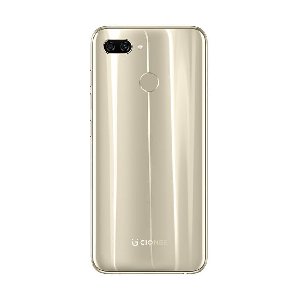

In [164]:
view_results(val_preds_check, 5000)

In [113]:
# baseline
val_preds_check['Color Family'].value_counts()/len(val_preds_check)

26.0    0.470374
10.0    0.231990
0.0     0.108744
12.0    0.050303
13.0    0.043223
19.0    0.034585
4.0     0.024200
20.0    0.014283
6.0     0.005707
2.0     0.003836
25.0    0.003711
7.0     0.002370
1.0     0.002339
14.0    0.002089
11.0    0.001279
18.0    0.000437
16.0    0.000343
17.0    0.000187
Name: Color Family, dtype: float64

In [114]:
mobile_lookup['Color Family'][0]

'gold'

In [191]:
# write function to evaluate MAP@2

In [185]:
val_preds_check.sample(5)

,index,itemid,image_path,Color Family,preds
15913,67578,1058601793,080dab621993dbd146a8792002a51f68.jpg,26.0,26 10
4214,38336,607058297,f4f969382f30e31f04a97f5ace86df55.jpg,10.0,26 10
15040,23522,1283240990,8d58226fe68360fdff9f405b9df0f66d.jpg,12.0,26 0
13396,153043,1287583541,ec654c0d0750b935e84a7e9508243fd2.jpg,26.0,26 10
1347,118390,1693180232,9ed760fdcd5e19ce63c3fcd208994888.jpg,26.0,26 10


In [188]:
map_per_image(val_preds_check.loc[4214, 'Color Family'], val_preds_check.loc[4214, 'preds'])

0.5

In [189]:
map_per_set(val_preds_check['Color Family'], val_preds_check['preds'])

0.5653807771471341

#### Appendix

In [136]:
# # taken from https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
# def apk(actual, predicted, k=10):
#     """
#     Computes the average precision at k.
#     This function computes the average prescision at k between two lists of
#     items.
#     Parameters
#     ----------
#     actual : list
#              A list of elements that are to be predicted (order doesn't matter)
#     predicted : list
#                 A list of predicted elements (order does matter)
#     k : int, optional
#         The maximum number of predicted elements
#     Returns
#     -------
#     score : double
#             The average precision at k over the input lists
#     """
#     if len(predicted)>k:
#         predicted = predicted[:k]

#     score = 0.0
#     num_hits = 0.0

#     for i,p in enumerate(predicted):
#         if p in actual and p not in predicted[:i]:
#             num_hits += 1.0
#             score += num_hits / (i+1.0)

#     if not actual:
#         return 0.0

#     return score / min(len(actual), k)

# def mapk(actual, predicted, k=10):
#     """
#     Computes the mean average precision at k.
#     This function computes the mean average prescision at k between two lists
#     of lists of items.
#     Parameters
#     ----------
#     actual : list
#              A list of lists of elements that are to be predicted 
#              (order doesn't matter in the lists)
#     predicted : list
#                 A list of lists of predicted elements
#                 (order matters in the lists)
#     k : int, optional
#         The maximum number of predicted elements
#     Returns
#     -------
#     score : double
#             The mean average precision at k over the input lists
#     """
#     return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])